# The Northwind Database: Do discounts matter and Other Analysis

Northwind Traders Access database is a sample database that was created by Microsoft. The database houses sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world. 

Below you can see the schema for the database.  The Schema provided below has some typos in it so some of our code will be slightly different than what is listed in the map.

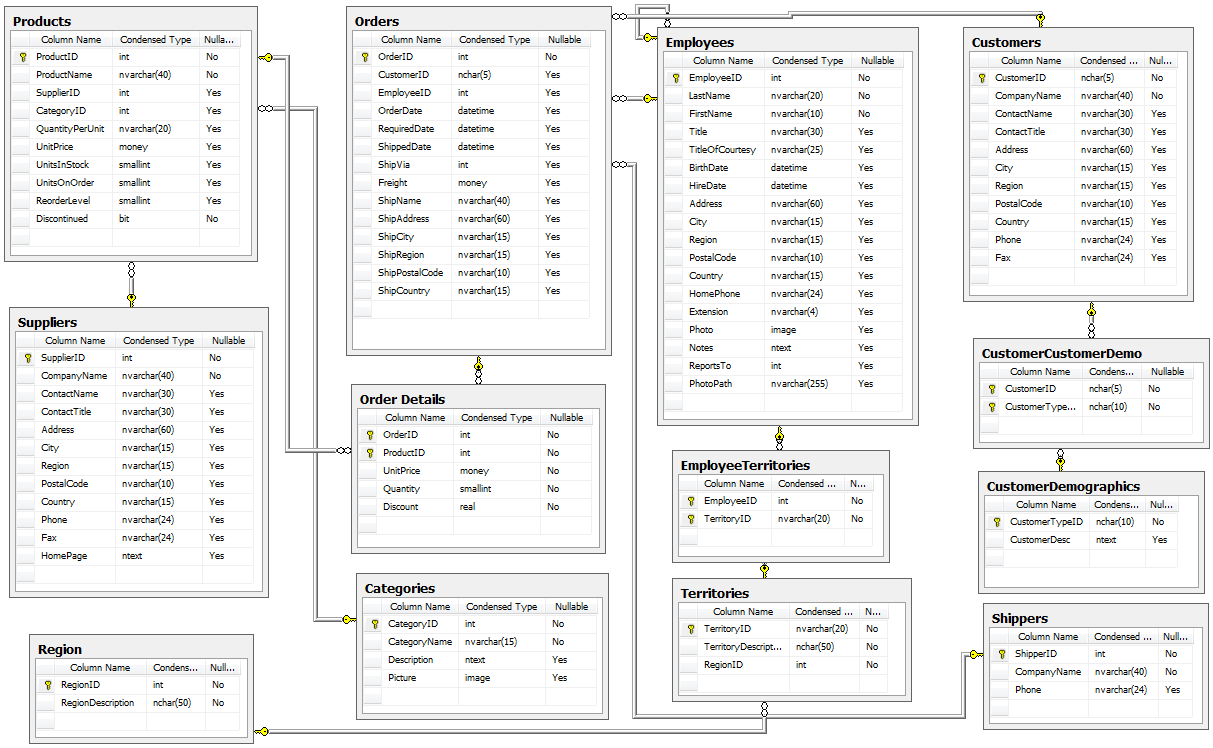

## Let's Ask Our First Question

### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

The test we will perform will be at a 5% alpha or a 95% confidence level.  Since we are doing hypothesis testing we should also clearly state our null and alternate hypothesis:

### Null Hypothesis =  Ho: There is no effect of Discount on the number of products per order

### Alternate Hypothesis = Ha: There is a positive effect of having a discount and the number of products per order.

We'll start with importing some of the necessary libraries.  We will certainly add more as we work through our analysis, but this should get us started.

Then we'll use some SQL joins to get all the necessary data from the database and into a pandas dataframe.

In [1]:
# Importing the required libraries
import sqlite3 
import pandas as pd
from pandasql import sqldf
import numpy as np

#keeping our notebook clean by ignoring filter warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Creating a connection and cursor with SQLite
conn = sqlite3.connect('Northwind_small.sqlite',detect_types=sqlite3.PARSE_COLNAMES)
cur = conn.cursor()

In [3]:
# Extracting the data required as a pandas dataframe using a SQL query
cur.execute("""SELECT * FROM orderdetail;""")

df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


We're going to remove the ID column because pandas to make our table cleaner.

In [4]:
#dropping the id column and checking the resulting dataframe
df = df.drop('Id', axis =1)
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


Great, the data loaded properly.  Now we can get a feel for our data. So we can look at various summary statistics to see what exactly we have to work with.

In [5]:
#looking at the info to see what type of data we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3)
memory usage: 84.3 KB


In [6]:
#checking our summary statistics
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


I want to know how many orders there are so we're also taking a look at the unique values in the OrderID column 

In [7]:
len(df.OrderId.unique())

830

So we have 830 individual orders, with an average order of 23 items per order.  Let's see what the distribution looks like next.

In [8]:
#importing our visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

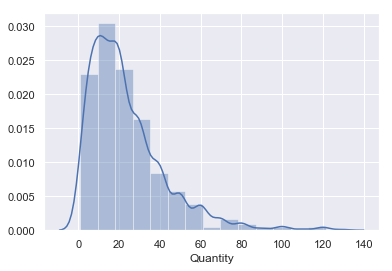

In [9]:
#looking at our plot
sns.set(); np.random.seed(0)
ax = sns.distplot(df.Quantity, bins=15, hist=True)


Let's look at another plot and start to formulate the answer to our first question.

We're going to look at quantity only where discounts are not 0!

In [10]:
#making a dataframe copy and then slicing only the part of the database where a discount was applied (i.e. Discount>0)
disc_df = df.copy()

disc_df = disc_df.loc[disc_df['Discount'] > 0]
disc_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250,51,42.4,35,0.15
7,10250,65,16.8,15,0.15
8,10251,22,16.8,6,0.05
9,10251,57,15.6,15,0.05
11,10252,20,64.8,40,0.05


In [11]:
#looking at new summary statistics
disc_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,838.000000,838.000000,838.000000,838.000000,838.000000
mean,10654.007160,39.844869,26.292363,27.109785,0.144439
std,235.887125,22.046812,30.017214,20.771439,0.071808
min,10250.000000,1.000000,2.000000,1.000000,0.010000
25%,10452.250000,21.000000,12.500000,12.000000,0.100000
50%,10645.000000,40.000000,18.000000,20.000000,0.150000
75%,10847.000000,59.000000,31.230000,36.000000,0.200000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


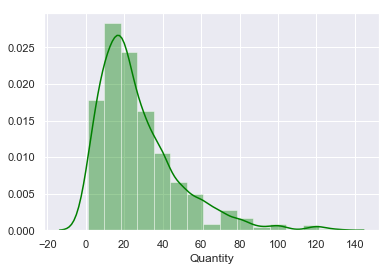

In [12]:
#looking at the new plot - this is for infromation gathering, we will be operating on our original dataframe
ax2 = sns.distplot(disc_df.Quantity, bins=15, hist=True, color = 'green')

Much smoother.  Our data still looks heavily skewed right (long right tail) so using an ANOVA test for our hyposthesis wouldn't work well.  To fix this what we can do is log-transform the data to get closer to a normal distribution.  Then we can do our first test.

In [13]:
# we're going to show our test statistics using our first dataframe - that's the data we are really after
df_log = df.copy()
disc_df_log = disc_df.copy()

df_log['Quantity']=np.log(df['Quantity'])
disc_df_log['Quantity']=np.log(disc_df['Quantity'])

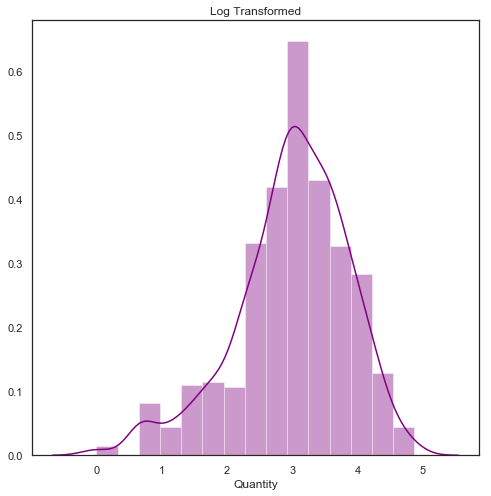

In [14]:
#plotting again with our logtransformed data
sns.set(style="white", palette="muted", color_codes=True)
f = plt.figure(figsize=(8,8))

ax_log = sns.distplot(disc_df_log.Quantity, bins=15, hist=True, color = 'purple')

ax_log.set_title('Log Transformed')

plt.show()

This is bell curve is more normal and given the number of observations we can move forward now.

In [15]:
#importing the statistical packages we plan to use
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [16]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('Quantity ~ C(Discount)', df_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),82.463740,10.0,11.311846,4.349593e-19
Residual,1562.983265,2144.0,NaN,NaN


The ANOVA table above shows a p-value that is lower than the alpha value of 5% (0.05). 

Therefore, we are able to reject the null hypothesis and accept the alternative hypothesis.  

Great!  This is part a of our question answered.  Now what about part b?  Just how significant is this effect?

We can use Cohen's d to quanitfy the effect.  Before we do that we have a little bit more work to do.

The data was already split into a dataframe with just those purchases that have discounts.  We'll need to pull the other sub-set of the data, those with no discounts, into a separate dataframe as well, for ease of calculation.  

In [17]:
#making a dataframe copy and then slicing our dataframe as above
nodisc_df = df.copy()

nodisc_df = nodisc_df.loc[nodisc_df['Discount'] == 0]
nodisc_df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [18]:
#looking at summary statistics
nodisc_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.0
mean,10662.791951,41.396355,26.171534,21.715262,0.0
std,244.835366,22.217410,29.717354,17.507493,0.0
min,10248.000000,1.000000,2.000000,1.000000,0.0
25%,10448.000000,23.000000,12.000000,10.000000,0.0
50%,10671.000000,41.000000,18.400000,18.000000,0.0
75%,10879.000000,60.000000,32.800000,30.000000,0.0
max,11077.000000,77.000000,263.500000,130.000000,0.0


In [19]:
#log transforming our new slice 
nodisc_df_log = nodisc_df.copy()
nodisc_df_log['Quantity']=np.log(nodisc_df_log['Quantity'])

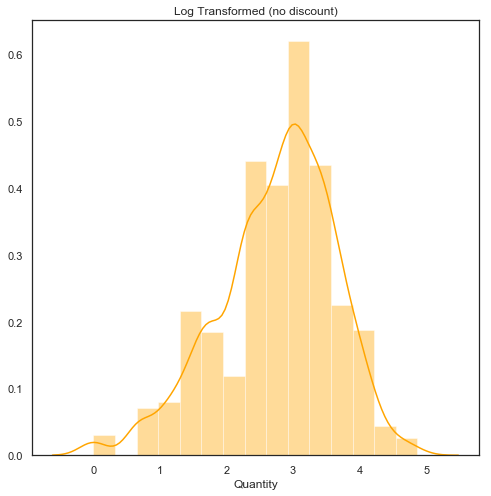

In [20]:
#plotting our no discount log-transformed data
f = plt.figure(figsize=(8,8))

ax_log = sns.distplot(nodisc_df_log.Quantity, bins=15, hist=True, color = 'orange')

ax_log.set_title('Log Transformed (no discount)')

plt.show()

Now let's overlap these two graphs

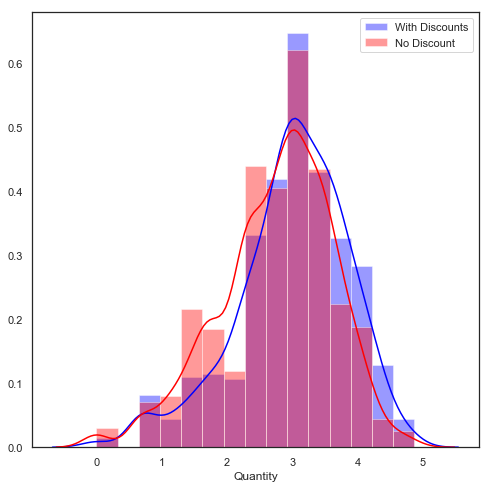

In [21]:
#plotting again with our logtransformed data
sns.set(style="white", palette="muted", color_codes=True)
fig = plt.figure(figsize = (8,8))
ax_log1 = sns.distplot(disc_df_log.Quantity, bins=15, hist=True, color = 'blue', label= 'With Discounts')
ax_log2 = sns.distplot(nodisc_df_log.Quantity, bins=15, hist=True, color = 'red', label = 'No Discount')



plt.legend()
plt.show()

Cohen's d is a very common statistic to show the two or more groups on a given variable.  It represents the difference of each group's mean standardized by the pooled standard deviation and gives us a dimensionless value for easy comparisons.

In [22]:
#we're going to define a function for Cohen's d so we can reuse it when we do other hypothesis tests.

def Cohen_d(group1, group2):

    # Compute Cohen's d : difference of each group's mean standardized by the pooled standard deviation

    # group1: Series or NumPy array
    # group2: Series or NumPy array
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

Now we can compute the statistic to see if the difference matters.  We can use the below rule of thumb:

Small effect = 0.2

Medium Effect = 0.5

Large Effect = 0.8

In [23]:
round(Cohen_d(disc_df_log['Quantity'], nodisc_df_log['Quantity']),4)


0.2744

So our effect size is practically small, but still statistically significant.  

What does this mean?  Customers buy more products when there are discounts (accepting our alternate hypothesis), but the increase in quantity is small enough (small-ish Cohen's d) that it might not be enough to change business strategy.  

## Now if our strategy...

...had nothing to do with the quantity of products and everything to do with the how much money they spend, we'd have more work to do.  After all, it's always about the bottom line.  Does having a discount available make our customers actually spend more?

Let's state our next hypothesis and walk through our analysis.


### Null Hypothesis: Ho = There is no effect of discount on the amount of money spent per product.
### Alternate Hypothesis = Ha: There is a positive effect of having a discount and the amount spent per product.

In [24]:
#let's look at our data again
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


We only have unit prices, not total cost so we will need to add another series with this calculation

In [25]:
#an additional note on our calculation - we included the discount amount so we can get totals later if needed
df['PriceQty'] = df['Quantity'] * df['UnitPrice']-(df['Discount']*df['Quantity'] * df['UnitPrice'])
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,PriceQty
0,10248,11,14.0,12,0.0,168.0
1,10248,42,9.8,10,0.0,98.0
2,10248,72,34.8,5,0.0,174.0
3,10249,14,18.6,9,0.0,167.4
4,10249,51,42.4,40,0.0,1696.0


Great!! Now we should have a look at our distplot to see what that looks like.

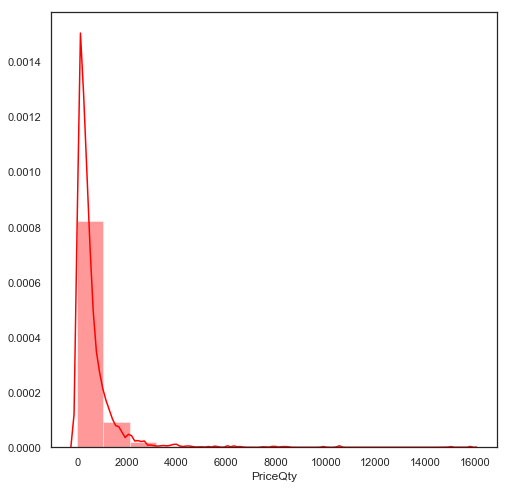

In [26]:
sns.set(style="white", palette="muted", color_codes=True)
fig = plt.figure(figsize=(8,8))
ax3 = sns.distplot(df.PriceQty, bins=15, hist=True, color = 'red')


And the log transformed version next since that is clearly not a normal bell curve.

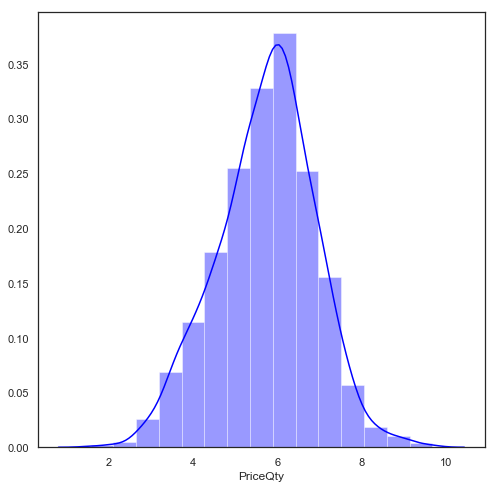

In [27]:
df2_log = df.copy()
df2_log['PriceQty']=np.log(df['PriceQty'])
fig = plt.figure(figsize=(8,8))
ax3 = sns.distplot(df2_log.PriceQty, bins=15, hist=True, color = 'blue')

Then we can fit our ANOVA model just like we did above


In [28]:
#Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm2 = ols('PriceQty ~ C(Discount)', df2_log).fit()
sm.stats.anova_lm(lm2, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),50.295740,10.0,3.789263,0.000044
Residual,2845.779513,2144.0,NaN,NaN


Once again since our p-value is less than the alpha value of 0.05 we set at the begining of our testing, we can reject the Null Hypothesis and Accept the Alternate Hypothesis that there is a postive effect on the amount spent by including a discount.

In [31]:
#splitting our dataframe into discount and non -discount 
disc_df2_log = df2_log.copy()
nodisc_df2_log = df2_log.copy()

nodisc_df2_log = nodisc_df2_log.loc[nodisc_df2_log['Discount'] == 0]
disc_df2_log = disc_df2_log.loc[disc_df2_log['Discount'] > 0]


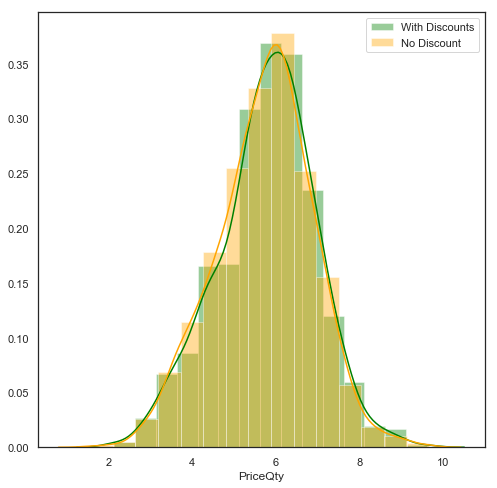

In [32]:
#then plotting both on the same graph as we did before
nodisc_df2_log = df2_log.copy()
sns.set(style="white", palette="muted", color_codes=True)
fig= plt.figure(figsize = (8,8))

ax_log1 = sns.distplot(disc_df2_log.PriceQty, bins=15, hist=True, color = 'green', label= 'With Discounts')
ax_log2 = sns.distplot(nodisc_df2_log.PriceQty, bins=15, hist=True, color = 'orange', label = 'No Discount')

plt.legend()
plt.show()

In [33]:
round(Cohen_d(disc_df2_log['PriceQty'], nodisc_df2_log['PriceQty']),4)

0.0443

So similarly to the first test our effect size is practically small, but still statistically significant.  

What does this mean?  Customers spend more when there are discounts (accepting our alternate hypothesis), but the increase in dollars spent is small enough (small-ish Cohen's d) that it might not be enough to justify a change to Northwind's business model.  

Let's take a look then at some different parts of the database that will require us to pull in more data and join tables together into a single dataframe.  This will allow us to ask some additional questions.  So what can we ask?

## Does the average revenue per order vary between the regional customer segements?

We should state our hypothesis that reflects this question and then we'll use our SQL to pull data into pandas again.  

### Null Hypothesis: Ho = There is no difference in revenue from customers across different regions
### Alternate hypothesis: Ha = The average amount spent per order is different (either higher or lower) between  customers across different regions

And just a reminder, our alpha is 0.05 or 5%.

In [35]:
# Extracting the data required as a pandas dataframe using a SQL query this time from SQLalchemy

#importing SQLAlchemy 
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

# Creating a new engine and connecting to the database using the SQLAlchemy library (instead of SQLite3)
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

# Extracting the data into a pandas dataframe
df3 = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', engine)

#checking our dataframe
df3.head()

2019-04-18 12:02:35,913 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1


2019-04-18 12:02:35,915 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2019-04-18 12:02:35,918 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1


2019-04-18 12:02:35,920 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2019-04-18 12:02:35,926 INFO sqlalchemy.engine.base.Engine 
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 


INFO:sqlalchemy.engine.base.Engine:
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 


2019-04-18 12:02:35,929 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [36]:
# Calculating the revenue on each line
df3['price_per_order'] = df3.Quantity * df3.UnitPrice * (1 - df3.Discount)
# Dropping the columns now that we have the revenue calculated
df3.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)
# Grouping the data by order and summing the revenue for each order
df3 = df3.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()
# Dropping the OrderId since we don't need this anymore
df3.drop('OrderId', axis=1, inplace=True)

In [37]:
#reviewing our dataframe again
df3.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


Lets look at a count of the orders by each of the regions.

In [38]:
df3.groupby(['Region']).count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


If we want to do ANOVA analysis again we need to combine a few of the regions to ensurerelatively equal sample sizes, satifying the assumption of equal variances. Smaller groups need to be combined with other groups (that make sense geographically).  We can set our minimum group size to 30.


In [39]:
# Eastern and Southern Europe
df3.loc[(df3.Region == 'Eastern Europe') | (df3.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'
# Scandinavia and Northern Europe
df3.loc[(df3.Region == 'Scandinavia') | (df3.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'
#Central and South America
df3.loc[(df3.Region == 'Central America') | (df3.Region == 'South America'),'Region'] = 'South and Central America'


#reviewing the changes to the dataframe
df3.groupby(['Region']).count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


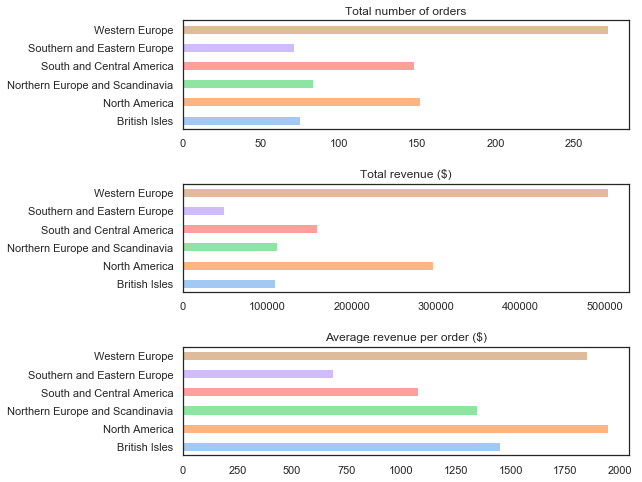

In [51]:
# Plotting the number of orders, total revenue per order and average revenue per order for each region
sns.set(style="white", palette="pastel", color_codes=True)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
df3.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df3.groupby(['Region'])['price_per_order'].sum().plot(kind='barh', ax=ax2)
df3.groupby(['Region'])['price_per_order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=.5);

There's quite a bit of information we can learn from these visualizations.  Firstly, Western Europe has the greatest number of orders, and also has the highest total revenue.  North America spends the most per order on average.  The Southern and Eastern Europe region has the lowest number of orders, least total revenue, and spends the least per order on average. 

It looks like our alternative hypothesis has some support from the third graph.  We will continue with our hypothesis testing to see if it is statistically significant.


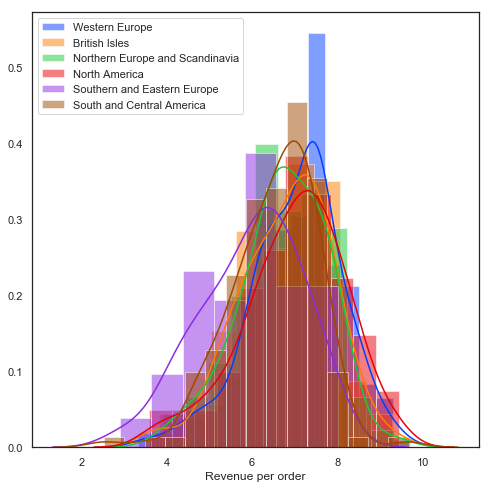

In [56]:
# Copying the dataset and log-transforming price_per_order to smooth our bell curve
sns.set(style = "white", palette = "bright")
df3_log = df3.copy()
df3_log['price_per_order'] = np.log(df3['price_per_order'])
# Plotting the distributions for the log-transformed data
plt.figure(figsize=(8,8))
for region in set(df3_log.Region):
    region_group = df3_log.loc[df3_log['Region'] == region]
    sns.distplot(region_group['price_per_order'], hist_kws=dict(alpha=0.5), label=region)
    plt.legend()
    plt.xlabel('Revenue per order')

In [57]:
# Once again performing our ANOVA test, this time for price/order and region

lm = ols('price_per_order ~ C(Region)', df3_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),77.999547,5.0,13.032374,3.285724e-12
Residual,951.624641,795.0,NaN,NaN


Here again our p-value is less than our alpha of 0.05 so we are able to reject the null hypothesis and accept the alternative hypothesis.